# Analyze A/B Test Results 



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.
<a id='probability'></a>

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

We will store the data in [df] with the help of the [pd.read_csv] function 

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [3]:
df['user_id'].unique().shape[0]

290584

The proportion of users converted.

In [4]:
df[df['converted'] == 1].shape[0]/df.shape[0]

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [5]:
df.query("(group == 'treatment' and landing_page == 'old_page')").shape[0]

1965

Check if any of the rows have missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

Here we make new data set that dose not have any rows with the previous issue and call it df2

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2=df.drop(df[(df['group'] != 'treatment') != (df['landing_page'] != 'new_page')].index)

In [9]:
# Double Check all of the incorrect rows were removed from df2 -
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

chack How many unique **user_id**s are in **df2** 

In [10]:
df2['user_id'].unique().shape[0]

290584

Check if there is any **user_id** repeated in **df2**.

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates(['user_id'])

Here we chack what is the probability of an individual converting regardless of the page they receive

In [44]:
df2[df2['converted']==1].shape[0]/df2.shape[0]

0.11959667567149027

Given that an individual was in the `control` group, here is the probability they converted

In [15]:
rate_control= df2[(df2['group'] == 'control')&(df2['converted']==1)].shape[0]/df2[df2['group'] =='control'].shape[0]
rate_control

0.1203863045004612

Given that an individual was in the `treatment` group, here is the probability they converted

In [16]:
rate_treatment= df2[(df2['group'] == 'treatment')&(df2['converted']==1)].shape[0]/df2[df2['group'] =='treatment'].shape[0]
rate_treatment

0.11880806551510564

Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups.

In [20]:
obs_diff=rate_treatment -rate_control
obs_diff

-0.0015782389853555567

here is the probability that an individual received the new page 

In [19]:
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

Consider your results from the previous parts above, no the new `treatmen` don't lead to more conversions.

<a id='ab_test'></a>
## A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability for the old page is *slightly* higher than that of the new page. 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**null 𝐻0:P𝑜𝑙𝑑 >= Pnew**


>**alternative H1:P𝑜𝑙𝑑 < Pnew.**

###  Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


Here is the **conversion rate** for $p_{new}$ under the null hypothesis.

In [22]:
p_new = df2['converted'].mean()

p_new

0.11959708724499628

Here is the **conversion rate** for $p_{old}$ under the null hypothesis.

In [23]:
p_old=df2['converted'].mean()

p_old

0.11959708724499628

Here is $n_{new}$, the number of individuals in the treatment group.

In [24]:
n_new=df2[df2['group']=='treatment'].shape[0]

Here is $n_{old}$, the number of individuals in the control group.

In [25]:
n_old=df2[df2['group']=='control'].shape[0]

Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [26]:
new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
new_page_converted.mean()

0.11926914871653706

 Simulate Sample for the `control` Group <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. 

In [27]:
old_page_converted = np.random.choice([1,0],size=n_old,p=[p_old, 1-p_old])
old_page_converted.mean()

0.11974613488993213

Here the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the previous parts 

In [28]:
obs_diff=df2['converted'][df2['landing_page']=='new_page'].mean()-df2['converted'][df2['landing_page']=='old_page'].mean()
obs_diff

-0.0015782389853555567


**Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

In [29]:
# Sampling distribution 
p_diffs = []
for o in range(10000):
    old_page_converted = np.random.choice([1,0],size=n_old,p=[p_old, 1-p_old])
    new_page_converted=np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


**Histogram**<br>   

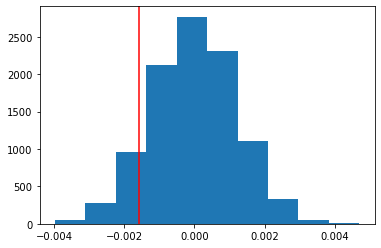

In [30]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='r');

In [31]:
p_diffs=np.array(p_diffs)
null_value=np.random.normal(0,p_diffs.std(),p_diffs.size)


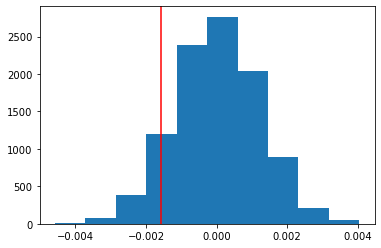

In [32]:
plt.hist(null_value);
plt.axvline(x=obs_diff, color='r');

Here proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data.

In [33]:
(null_value>obs_diff).mean()

0.9091

>**اhere we just get the p-value which is 0.9.**

>**small p-value mean that we will reject the alternative hypothesis that mean that the old is butter than the new page .**



**Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =df2[(df2['landing_page']=='old_page')&(df2['converted']==1)].shape[0]

# number of conversions with the new_page
convert_new =df2[(df2['landing_page']=='new_page')&(df2['converted']==1)].shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page']=='old_page'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page']=='new_page'].shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.





---


In [35]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new] , alternative='larger')
print(z_score, p_value)

1.3109241984234394 0.09494168724097551


In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old] , alternative='smaller')
print(z_score, p_value)

-1.3109241984234394 0.09494168724097551


>**z_score mean the test statistic for the z-test and the p-values mean if the null hypothesis is true or no, that mean becuse the p-value is small that we will notreject the null hypothesis with 95% confidence.**

<a id='regression'></a>
### A regression approach


In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 



In [37]:
df2['intercept'] =1
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
del df2['control']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [38]:

lm=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jan 2024   Pseudo R-squ.:               8.077e-06
Time:                        20:25:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jan 2024   Pseudo R-squ.:               8.077e-06
Time:                        20:25:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

>**H0: pnew−pold=0
.**

>**H1: pnew−pold≠0.**

>**null hypotheses is H0: B=0 and the alternative hypotheses is H1: B!=0
, the valus are differ becuse the value based on the number of groups minus one instead of the total number of observations minus the number of explanatory variables. the two of the parts are one sided .**

>**the p-value are the  probability of the null hypothesis being correct,
   the type 1 error is the probability of p-value to be mistake .**

>**the the more you add factor the more chance to make the model fit butter but if the factor are not related that we make the model worse.**

In [40]:
# Read the countries.csv
df3=pd.read_csv('countries.csv')
df3[['UK','US','CA']]=pd.get_dummies(df3['country'])
del df3['CA']
del df3['country']

df3.head()


,user_id,UK,US
0,834778,0,1
1,928468,0,0
2,822059,0,1
3,711597,0,1
4,710616,0,1


In [41]:
# Join with the df2 dataframe
df2=pd.merge(df2, df3, on=['user_id'])
df2['UK_new'] = df2['UK'] * df2['ab_page']
df2['US_new'] = df2['US'] * df2['ab_page']
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_new,US_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,0,0


In [42]:
# Create the necessary dummy variables
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_new,US_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,0,0


<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 




In [43]:
# Fit your model, and summarize the results
lm=sm.Logit(df2['converted'],df2[['intercept','ab_page','UK','US','UK_new','US_new']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 23 Jan 2024   Pseudo R-squ.:               3.482e-05
Time:                        20:26:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_new        -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_new         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

>**the p-values is ab_page:0.191 ,UK:0.130 ,US:0.457 ..**

>**we will fall to  reject null hypotheses.**

>**the effect of the page is make the converted worse.**